# S-wave scattering phase shifts

In [1]:
from scipy.integrate import odeint
from scipy.special import struve, yn, riccati_jn, riccati_yn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

### SI units

In [2]:
# SI units
N = 2048 # number of points
hbar = 1.0545718e-34 # [Js]
eV = 1.602176634e-19 # [J]
meV = 1e-3 * eV
e_charge = 1.60217662e-19 # [C]
au = 1.64877727436e-41 # [C^2 m^2 J^(-1)] 

angstrom = 1e-10 # [m]
R = angstrom
r = np.linspace(1e-6, 200, N) * angstrom

### Parameters form tables 1 and 2

In [27]:
# table 1.
r_0 = 44.6814 * angstrom # [m]
mass_e = 9.10938356e-31 # [kg]
mass_eff_e = 0.47 * mass_e 
mass_eff_h = 0.54  * mass_e
# mass_X = mass_eff_e + mass_eff_h
M_red = mass_eff_e * mass_X / (mass_eff_e + mass_X) # negative trion
# M_red = mass_eff_h * mass_X / (mass_eff_h + mass_X) # positive trion 
print('The reduced mass:', M_red / mass_e)

# table 2
r_star = 34 * angstrom  # only symmetric phase shift
v_0 = -58.5 * meV
alpha = 52 * (10**3) * au 
print('The polarisability:',alpha)

The reduced mass: 0.3207432432432432
The polarisability: 8.573641826672e-37


### Energy and wave vector

In [28]:
E_min = 0.1 * meV
E_max = 60 * meV
E = np.linspace(E_min, E_max, N)
k = np.sqrt(2 * M_red * E) / hbar

# IV Electron-exciton scattering
### (Schmidt et al.)

In [29]:
# au = 1.64877727436e-41 / eV # [C^2 m^2] 
# alpha = 52 * 10**3 * au

epsilon = 8.854e-12 

def keldysh(r):
    # equation (2) 
    # [V]
    
    V_K = (np.pi / (2 * ( 4 * np.pi * epsilon) * r_0) * (struve(0, r / r_0) - yn(0, r / r_0)))
    return V_K

def V_Xe(r): 
    # equation (8)
    # [J]    
    r = np.array(r)
    dr = r_0 / 1000
    V_Xe = np.zeros_like(r)
    V_Xe[abs(r) <= r_star] = v_0 
    V_Xe[r > r_star] = - (alpha * e_charge **2 / 2) * ((keldysh(r[r > r_star] + dr) - keldysh(r[r > r_star])) / dr)**2
    V_Xe[r < -r_star] = - (alpha * e_charge **2 / 2) * ((keldysh(abs(r)[r < -r_star] + dr) - keldysh(abs(r)[r < -r_star])) / dr)**2

    # print(r)
    return V_Xe

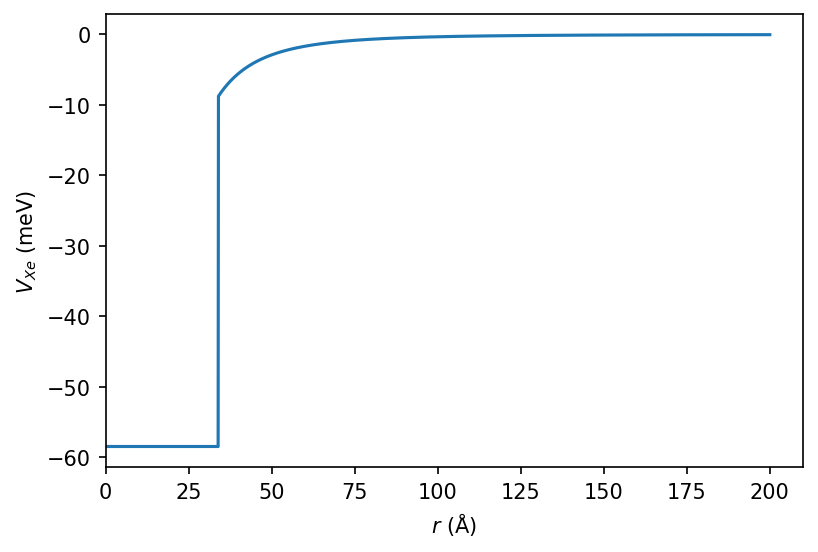

In [30]:
plt.plot(r / angstrom, V_Xe(r) / meV)
ylabel = plt.ylabel(r'$V_{Xe}$ (meV)', fontsize=10)
plt.xlabel(r'$r$ (Å)')
plt.savefig('V_Xe_Schmidt.png')
plt.axis(xmin=0)
plt.show()

### BOUND STATES
Assume ($\ell = 0$)
 
Solve the 2D radial Schrodinger wave equation as the eigenvalue problem
$A \overrightarrow{R} = \lambda \overrightarrow{R}$:

 $\frac{d^2 R}{dr^2} + \frac{1}{r}\frac{dR}{dr} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r) R = \frac{-2 M_{Red} E}{\hbar^2} R$
 
 $(\frac{d^2}{dr^2} + \frac{1}{r}\frac{d}{dr} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r))R = -k^2 R$

where $A = \frac{d^2}{dr^2} + \frac{1}{r} \frac{d}{dr} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r)$ and $\lambda = -k^2$

### CHANGE OF VARIABLES

given that $u(r) = \sqrt{r}R(r)$

$ \therefore A = \frac{d^2}{dr^2} + \frac{u(r)}{4 r^2} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r)$ and $\lambda = -k^2$

where the term: $\frac{u(r)}{4 r^2} - \frac{2 M_{red}}{\hbar^2} V_{Xe}(r)$ can be condensed into a single potential term.

Now we can approximate $\frac{d^2u(r)}{dr^2}$ using second order centered finite  differences and impose periodic BCS.

In [31]:
# setting up our matrices:
A = np.zeros((N,N)) # main matrix
dr = r[1] - r[0] # step size

second_dR = np.zeros_like(A) # second derivative matrix (mixed? order approximation)
for j in range(N):
    if j == 0:
        second_dR[j, j] = 35 / 12
        second_dR[j, j+1] = -104 / 12
        second_dR[j, j+2] = 114 / 12
        second_dR[j, j+3] = -56 / 12
        second_dR[j, j+4] = 11 / 12
    elif j == 1:
        second_dR[j, j-1] =  11 / 12
        second_dR[j, j] = -20 / 12
        second_dR[j, j+1] = 6 / 12
        second_dR[j, j+2] = 4 / 12
        second_dR[j, j+3] = -1 / 12
    elif 2 < j < N-3:
        second_dR[j, j-2] = -1 / 12
        second_dR[j, j-1] = 4 /3
        second_dR[j, j] = -5 / 2
        second_dR[j, j+1] = 4 / 3
        second_dR[j, j+2] = -1 / 12
    elif j == N-2:
        second_dR[j, j+1] =  11 / 12
        second_dR[j, j] = -20 / 12
        second_dR[j, j-1] = 6 / 12
        second_dR[j, j-2] = 4 / 12
        second_dR[j, j-3] = -1 / 12
    else:
        second_dR[j, j] = 35 / 12
        second_dR[j, j-1] = -104 / 12
        second_dR[j, j-2] = 114 / 12
        second_dR[j, j-3] = -56 / 12
        second_dR[j, j-4] = 11 / 12
print('Second_dR:\n')
print(second_dR)

Schmidt_matrix_eff = np.zeros_like(A)
for j in range(N):
    Schmidt_matrix_eff[j, j] = (1 / (4 * r[j]**2)) - (2 * M_red / hbar**2) * V_Xe(r[j])
# print('this is Schmidt_matrix')
# print(Schmidt_matrix_eff)


A = (1 / dr**2) * second_dR + Schmidt_matrix_eff # change of variables

# Diagonalise A
eigenvalues, unitary = np.linalg.eig(A) # unitary's columns are eigenvectors of A

Second_dR:

[[ 2.91666667 -8.66666667  9.5        ...  0.          0.
   0.        ]
 [ 0.91666667 -1.66666667  0.5        ...  0.          0.
   0.        ]
 [ 9.5        -8.66666667  2.91666667 ...  0.          0.91666667
  -4.66666667]
 ...
 [ 0.          0.          0.         ...  2.91666667  0.
   0.        ]
 [ 0.          0.          0.         ...  0.5        -1.66666667
   0.91666667]
 [ 0.          0.          0.         ...  9.5        -8.66666667
   2.91666667]]


### what's the ground state energy?

(cannot thest this easily anymore since the matrix is non-hermitian.)

In [32]:
# min_physical_n = 0
# E_ground = -(eigenvalues[N-1-min_physical_n] * hbar**2) / (2 * M_red) 
# print('The ground state energy [meV]:', E_ground / meV)

The ground state energy [meV]: (2.0134369303055455-0j)


eigenenergy 0: -4.40+0.00j meV
eigenenergy 1: +0.79+1.74j meV
eigenenergy 2: +0.79-1.74j meV
eigenenergy 3: +13.08+10.93j meV
eigenenergy 4: +13.08-10.93j meV
eigenenergy 5: +54.09+19.06j meV
eigenenergy 6: +54.09-19.06j meV
eigenenergy 7: +116.30+26.42j meV
eigenenergy 8: +116.30-26.42j meV


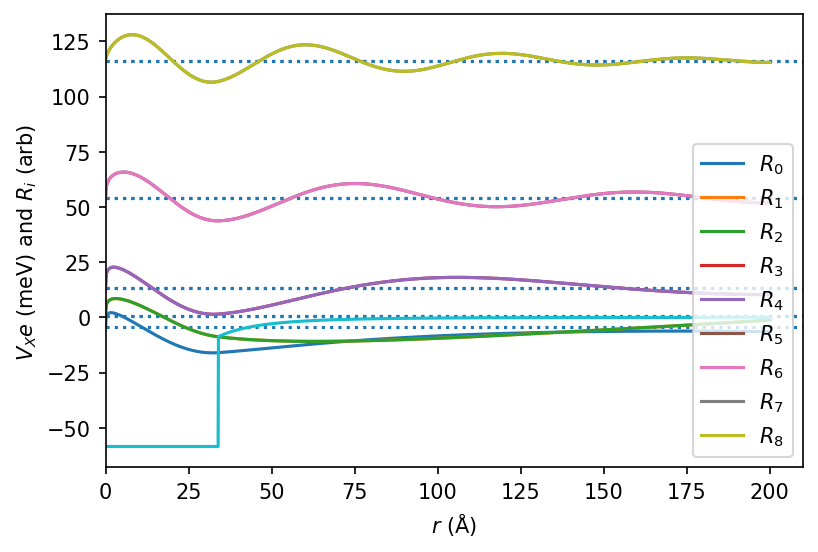

In [24]:
for n in range(min_physical_n, 9):
    i = N - 1 - n
    E_i = -(eigenvalues[i] * hbar**2) / (2 * M_red)
    plt.axhline(E_i /  meV, linestyle=":")
    plt.plot(
        r / angstrom,
        - np.sign(unitary[1,i] - unitary[0,i]) * v_0 * unitary[:, i] / (abs(unitary[:, i]).max() * 5  * meV) + E_i / meV,
        label=f"$R_{{{n - min_physical_n}}}$"
    )

    print(f"eigenenergy {n - min_physical_n}: {E_i / meV:+.02f} meV")
plt.legend(loc="lower right")
plt.axis(xmin=0)
plt.plot(r / angstrom, V_Xe(r) / meV)
ylabel = plt.ylabel(r'$V_Xe$ (meV) and $R_{i}$ (arb) ')
plt.xlabel(r'$r$ (Å)')
plt.savefig('state.png')
plt.show()

## Variable Phase Approach for (Schmidt et al.)
### Implementing Eq. (32)
$U(r) = V(r)/U_0$ where $U_0$ is the energy scale $U_0= \hbar^2 / (2m_r r_0)^2$ (in meV).

 * You should make sure that your phase shift is converged with respect to the distance (because it is formally defined when $r>>r_0$). So you can try to plot the phase shift as a function of r for a fixed k to check this. (???)
 

In [10]:
# U_0 = hbar**2 * meV / (2 * M_red * r_0)**2 

# # solve ODE using VPA for multiple k equation (32)
# def ODE_32(delta, r, k, V_0):
#     top = (2 * M_red * V_Xe(r) / U_0) * (np.cos(delta * riccati_jn(0, k * r )) - np.sin(delta * riccati_yn(0, k * r )))**2 ####? 
#     ddelta_dr = -(top / hbar * k ) ######### units of hbar**(-1) ?
#     return ddelta_dr

# # ODEINT solver
# for k_i in k:
#     delta= odeint(ODE_32, 0, r, args=(k_i, v_0))
#     # print accumulation of phase shift:
#     # print(delta[-1])